<a href="https://colab.research.google.com/github/thoongthuck/R-E/blob/main/VAD_%ED%9A%8C%EA%B7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오디오 VAD

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cmath
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#data load
audio_data = pd.read_csv('/content/drive/MyDrive/RNE/LGBM/LGBM_train.csv')

audio_labeled = pd.read_csv('/content/drive/MyDrive/RNE/LGBM/train/static_annotations_averaged_songs_1_2000.csv')

audio_labeled.rename(columns={'song_id':'id'},inplace=True)
audio_data.drop_duplicates(inplace=True)

VA = [' valence_mean',' arousal_mean']

audio_df = pd.merge(audio_labeled[['id']+VA],audio_data,on='id',how='inner')
audio_df.dropna(inplace=True)
audio_df[VA] = (audio_df[VA]-1)/8

<Axes: ylabel='Density'>

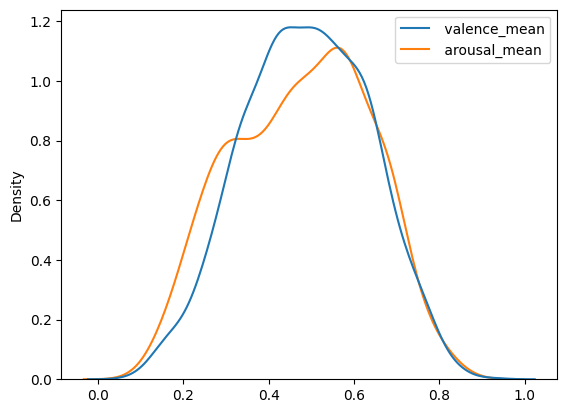

In [ ]:
sns.kdeplot(audio_df[VA])

V_regressor

In [ ]:
# data preprocessing
X = audio_df.iloc[:,3:]
y = audio_df[' valence_mean']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_test.shape

In [ ]:
# train
params = {
    'n_estimators': [600],
    'max_depth': [5],
    'learning_rate': [0.01],
    'min_data_in_leaf': [10],
    'feature_fraction': [0.6],
    'bagging_fraction': [0.8],
    'num_leaves': [50]
}

V_model = LGBMRegressor(
    bagging_freq=5,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    verbose=-1
  )

grid_cv = GridSearchCV(V_model,param_grid=params, cv=5, scoring='r2', refit=True)
grid_cv.fit(X_train, y_train)

best_V_model = grid_cv.best_estimator_
pred = best_V_model.predict(X_test)

r2 = r2_score(y_test, pred)
mse = np.sqrt(mean_squared_error(y_test, pred))
mae = mean_absolute_error(y_test, pred)

print('파라미터:\n', grid_cv.best_params_)
print(f'test R2: {r2:.4f}')
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')

In [ ]:
# importance
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = best_V_model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns)
ftr_top = ftr_importances.sort_values(ascending=False)

plt.figure(figsize=(8,6))
plt.title('Feature importances')
sns.barplot(x=ftr_top , y = ftr_top.index)
plt.show()

A_regressor

In [ ]:
X = audio_df.iloc[:,3:]
y = audio_df[' arousal_mean']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
params = {
    'n_estimators': [1000],
    'max_depth': [13],
    'learning_rate': [0.01],
    'min_data_in_leaf': [23],
    'feature_fraction': [0.6],
    'bagging_fraction': [0.6],
    'num_leaves': [12]
}

A_model = LGBMRegressor(
    boosting_type='dart',
    eval_metric='rmse',
    random_state=42,
    verbose=-1
  )

grid_cv = GridSearchCV(A_model,param_grid=params, cv=5, scoring='r2', refit=True)
grid_cv.fit(
    X_train, y_train,
    eval_set=[(X_test,y_test)]
  )

best_A_model = grid_cv.best_estimator_
pred = best_A_model.predict(X_test)

r2 = r2_score(y_test, pred)
mse = np.sqrt(mean_squared_error(y_test, pred))
mae = mean_absolute_error(y_test, pred)

print('파라미터:\n', grid_cv.best_params_)
print(f'test R2: {r2:.4f}')
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')

In [ ]:
ftr_importances_values = best_A_model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns)
ftr_top = ftr_importances.sort_values(ascending=False)

plt.figure(figsize=(8,6))
plt.title('Feature importances')
sns.barplot(x=ftr_top , y = ftr_top.index)
plt.show()

Mapping

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RNE/song_features.csv')

df = df.iloc[:,:46]
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 46 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         530 non-null    object 
 1   artist        530 non-null    object 
 2   tempo_bpm     530 non-null    float64
 3   rms_mean      530 non-null    float64
 4   rms_std       530 non-null    float64
 5   rms_db_mean   530 non-null    float64
 6   rms_db_std    530 non-null    float64
 7   mode_conf     530 non-null    float64
 8   mfcc_mean_0   530 non-null    float64
 9   mfcc_mean_1   530 non-null    float64
 10  mfcc_mean_2   530 non-null    float64
 11  mfcc_mean_3   530 non-null    float64
 12  mfcc_mean_4   530 non-null    float64
 13  mfcc_mean_5   530 non-null    float64
 14  mfcc_mean_6   530 non-null    float64
 15  mfcc_mean_7   530 non-null    float64
 16  mfcc_mean_8   530 non-null    float64
 17  mfcc_mean_9   530 non-null    float64
 18  mfcc_mean_10  530 non-null    

In [ ]:
feats = df.iloc[:,2:]
meta = df.iloc[:,:2]
feats.shape
for _ in range(len(feats)):
  V_pred = best_V_model.predict(feats)
  A_pred = best_A_model.predict(feats)
  meta['V_audio'] = V_pred
  meta['A_audio'] = A_pred

meta.to_csv('/content/drive/MyDrive/RNE/test/VA_audio.csv')
meta.head()

NameError: name 'best_V_model' is not defined

# 가사 VAD

In [ ]:
!pip install transformers sentencepiece -q

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
import torch.optim as optim
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F
import seaborn as sns

In [ ]:
# preprocessing
df = pd.read_csv('/content/drive/MyDrive/RNE/Bert/train/lyric_df_translated.csv')
df = df.drop('text',axis=1)
df.rename(columns={'trans':'text'},inplace=True)
df.dropna(subset=['text'],inplace=True)
df[['V','A','D']] = (df[['V','A','D']]-1)/4
df.describe()

,V,A,D
count,10054.000000,10054.000000,10054.000000
mean,0.494165,0.510472,0.515713
std,0.087208,0.064884,0.052423
min,0.050000,0.200000,0.195000
25%,0.450000,0.472500,0.500000
50%,0.500000,0.500000,0.522500
75%,0.530000,0.550000,0.550000
max,0.900000,0.850000,0.800000


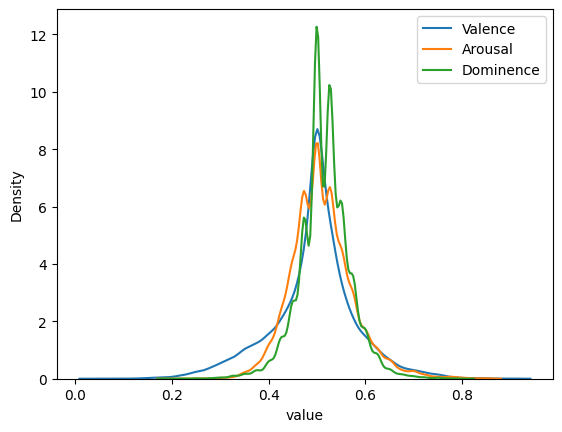

In [ ]:
sns.kdeplot(x=df['V'],label='Valence')
sns.kdeplot(x=df['A'],label='Arousal')
sns.kdeplot(x=df['D'],label='Dominence')
plt.xlabel('value')
plt.legend()
plt.show()

In [ ]:
MODEL_NAME = 'klue/bert-base'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
# dataset
class VADDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        self.texts = df['text'].tolist()
        self.labels = df[['V', 'A', 'D']].values
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            str(self.texts[idx]),
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt',
        )
        labels = torch.tensor(self.labels[idx], dtype=torch.float)
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': labels
        }

In [ ]:
import random

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [ ]:
# model
class KLUEBERT_VAD(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(768, 256, bias=True)
        self.fc2 = nn.Linear(256, 64, bias=True)
        self.fc3 = nn.Linear(64, 3, bias=True)

    def MLP(self, x):
      x = F.relu(self.fc1(x))
      x = self.dropout(F.relu(self.fc2(x)))
      x = self.fc3(x)
      return x

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden = outputs.last_hidden_state[:, 0, :]
        return self.MLP(self.dropout(hidden))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# dataLoader
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_ds = VADDataset(train_df, tokenizer)
val_ds = VADDataset(val_df, tokenizer)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)

In [ ]:
#model
model = KLUEBERT_VAD(MODEL_NAME).to(device)
for name, param in model.bert.named_parameters():
  if "layer.10" in name or "layer.11" in name:
      param.requires_grad = True
  else:
      param.requires_grad = False

optimizer = optim.Adam(model.parameters(),lr=1e-4)
criterion = nn.MSELoss()

In [ ]:
# train
EPOCHS = 7
patience = 3
best_loss = float('inf')
patience_counter = 0
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, 0, num_training_steps=total_steps)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        preds = model(input_ids, attention_mask)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # validation Loss
    model.eval()
    val_loss = 0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            preds = model(input_ids, attention_mask)
            loss = criterion(preds, labels)
            val_loss += loss.item()

            val_preds.append(preds.cpu().numpy())
            val_labels.append(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # early Stopping
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "/content/drive/MyDrive/rne/Bert/kluebert_vad.pt")
        print(f"모델 저장 ({best_loss:.4f})")
    else:
        patience_counter += 1
        print(f"개선 없음 ({patience_counter}/{patience})")

    if patience_counter >= patience:
        print("학습 중단")
        break

In [ ]:
# evaluation
model.eval()
val_preds, val_labels = [], []
with torch.no_grad():
  for batch in val_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    preds = model(input_ids, attention_mask)
    val_preds.append(preds.cpu().numpy())
    val_labels.append(labels.cpu().numpy())

val_preds = np.concatenate(val_preds, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

mse = mean_squared_error(val_labels, val_preds)
mae = mean_absolute_error(val_labels, val_preds)
r2 = r2_score(val_labels, val_preds)
print(f'mse: {mse:.4f} | mae: {mae:.4f} | R2: {r2:.4f}')

In [ ]:
# prediction
def predict_vad(text):
    model.eval()
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128).to(device)
        preds = model(inputs['input_ids'], inputs['attention_mask'])
        preds = preds.detach().cpu().numpy().flatten()
    return {'valence': float(preds[0]), 'arousal': float(preds[1]), 'dominance': float(preds[2])}

print(predict_vad("지배"))

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/rne/Bert/klue_vad.pt')

# Loaded Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model
MODEL_NAME = 'klue/bert-base'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
loaded_model = KLUEBERT_VAD(MODEL_NAME).to(device)

# load model
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/RNE/Bert/kluebert_vad.pt'))
print("모델이 성공적으로 불러와졌습니다.")

loaded_model.eval()

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

모델이 성공적으로 불러와졌습니다.


KLUEBERT_VAD(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [ ]:
# evaluation
loaded_model.eval()
val_preds, val_labels = [], []
with torch.no_grad():
  for batch in val_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    preds = loaded_model(input_ids, attention_mask)
    val_preds.append(preds.cpu().numpy())
    val_labels.append(labels.cpu().numpy())

val_preds = np.concatenate(val_preds, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

mse = mean_squared_error(val_labels, val_preds)
mae = mean_absolute_error(val_labels, val_preds)
r2 = r2_score(val_labels, val_preds)
print(f'mse: {mse:.4f} | mae: {mae:.4f} | R2: {r2:.4f}')

mse: 0.0029 | mae: 0.0404 | R2: 0.3637


In [ ]:
# prediction
def predict_vad(text):
    loaded_model.eval()
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128).to(device)
        preds = loaded_model(inputs['input_ids'], inputs['attention_mask'])
        preds = preds.detach().cpu().numpy().flatten()
    return {'valence': float(preds[0]), 'arousal': float(preds[1]), 'dominance': float(preds[2])}

print(predict_vad("안녕하세요!"))

In [ ]:
# data load
lyric_df = pd.read_csv('/content/drive/MyDrive/rne/lyric_df.csv',encoding='utf-8')
song_df = pd.read_csv('/content/drive/MyDrive/rne/VA_audio.csv',encoding='utf-8')

song_feat = pd.merge(song_df,lyric_df,on=['title','artist'])

song_feat.drop_duplicates(inplace=True,subset=['title', 'artist'])
song_feat.drop(['Unnamed: 0_x','Unnamed: 0_y'], axis=1, inplace=True)

song_feat.info()

In [ ]:
# Regress V-A-D
records = []

for idx, lyric in enumerate(song_feat['lyric']):
    predict = predict_vad(lyric)
    record = {
        "title": song_feat['title'].iloc[idx],
        "artist": song_feat['artist'].iloc[idx],
        "V_lyric": predict['valence'],
        "A_lyric": predict['arousal'],
        "D_lyric": predict['dominance']
    }
    records.append(record)

VAD_lyric = pd.DataFrame(records)
VAD_lyric = pd.merge(song_feat, VAD_lyric, on=['title','artist']).drop('lyric',axis=1)
VAD_lyric['V'] = 0.6*VAD_lyric['V_audio'] + 0.4*VAD_lyric['V_lyric']
VAD_lyric['A'] = 0.2*VAD_lyric['A_audio'] + 0.8*VAD_lyric['A_lyric']
VAD_lyric['D'] = VAD_lyric['D_lyric']
VAD_lyric.describe()

VAD_lyric.to_csv('/content/drive/MyDrive/VAD_song.csv')